<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2024</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Библиотека sklearn и классификация с помощью KNN</b></h1>

## Описание домашнего задания

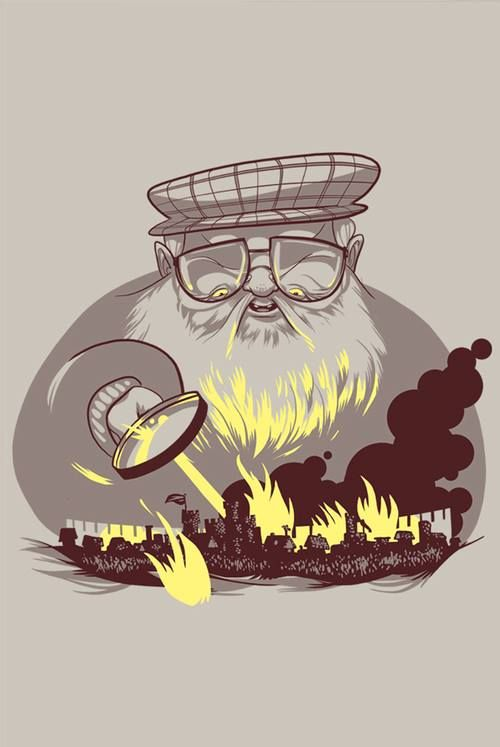

В данном задании вы будете работать с датасетом о персонажах из вселенной Игры Престолов [A Wiki of Ice and Fire](http://awoiaf.westeros.org/). Вам предстоит предсказать, кто из персонажей умрет, а кто останется вживых.



Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

Оценивание:

Баллы считаются следующим образом:

1) $1.00 \geqslant score \geqslant 0.84$ --- 5 баллов

2) $0.84 > score \geqslant 0.77$ --- 4 балла

3) $0.77 > score \geqslant 0.70$ --- 3 балла

4) $0.70 > score \geqslant 0.65$ --- 2 балла

5) $0.65 > score \geqslant 0.6$ --- 1 балл

6) $0.60 > score$ --- 0 баллов

## Часть 1. Анализ и предобработка данных

Здесь вам необходимо сделать все шаги, которые обсуждались в первой части семинара.
* Предобработка данных
  * Обработка пропущенных данных
  * Создание новых признаков
  * Удаление ненужных столбцов
* Анализ данных
  * Анализ целевой переменной
  * Анализ признаков
  * Анализ влияния признаков на целевую переменную
* Подготовка данных для обучения модели

Загружаем датасет

In [ ]:
# !gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
# !gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset

**Задание 1.1.** Импортируйте библиотеки pandas, matplotlib, seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Задание 1.2.** Загрузите датасет в Pandas DataFrame при помощи функции `read_csv`. Вместо дефолтных наименований строк `0,1,...`, при помощи параметра `index_col`, сделайте значения колонки `S.No` наименованиями строк:

In [ ]:
data = pd.read_csv('game_of_thrones_train.csv', index_col='S.No')

**Задание 1.3.** Предобработка (очистка) данных.

Проанализируйте, если в колонках NaN значения. Если есть, примите решение, как вы их будете обрабатывать. Вы можете либо удалить их, либо заполнить каким нибудь значением (например, медианой или модой).

In [ ]:
#посмотрим на количество NaN по столбцам
data.isna().sum()

name                   0
title                840
male                   0
culture             1069
dateOfBirth         1278
mother              1539
father              1535
heir                1536
house                381
spouse              1357
book1                  0
book2                  0
book3                  0
book4                  0
book5                  0
isAliveMother       1539
isAliveFather       1535
isAliveHeir         1536
isAliveSpouse       1357
isMarried              0
isNoble                0
age                 1278
numDeadRelations       0
popularity             0
isAlive                0
dtype: int64

Заполним пропущенные дома и культуры на основе фамилий персонажей

In [ ]:
#извлечем фамилию из текста имени персонажа
def nameProc(name):
    if '(' in name:
        surname = name[ : name.index('(')-1].split(' ')
        if len(surname) > 1:
            surname = surname[-1]
        else:
            surname = ''
    else:
        s = name.split(' ')
        if len(s) > 1:
            surname = s[-1]
        else:
            surname = ''
    return surname

data['surname'] = [nameProc(i) for i in data.name]

#восстановим культуру по фамилии
cultONsur = {}
cultnans = data.culture.isna() == False
cultnansT = data.culture.isna()
for s in data.surname.unique():
    family = data.surname == s
    s_cult = data.loc[family, 'culture'].mode()
    if s_cult.shape[0] > 0:
        data.loc[family&cultnansT, 'culture'] = s_cult[0]
        cultONsur.update({s:s_cult[0]})


In [ ]:
#восстановим дом по фамилии
housONsur = {}
housenans = data.house.isna() == False
housenansT = data.house.isna()
for s in data.surname.unique():
    family = data.surname == s
    s_house = data.loc[family, 'house'].mode()
    if s_house.shape[0] > 0:
        data.loc[family&housenansT, 'house'] = s_house[0]
        housONsur.update({s:s_house[0]})


In [ ]:
#поработаем с культурами и домами
cultnans = data.culture.isna() == False
cultnansT = data.culture.isna()
cultONhouse = {}
for i in data.house.unique():
    if not pd.isna(i):
        cond = data.house == i
        if sum(cond & cultnans) > 0:
            houseCult = data.loc[cond, 'culture'].mode()[0]
            data.loc[cond & cultnansT, 'culture'] = houseCult
            cultONhouse.update({i:houseCult})
            # print(houseCult)



#Дропать NaN'ы - не вариант, их слишком много. Будем заполнять модами и медианами.
#соберём эти наши моды и медианы в словарик

nareplaceVals = {}
for col in data.columns:
    if data[col].dtype == 'object':
        nareplaceVals.update({col : data[col].mode()[0]})
    else:
        nareplaceVals.update({col : data[col].median()})

#и заполним пропущенные значения
data.fillna(value=nareplaceVals, inplace=True)

**Задание 1.4.** Создайте новые признаки.
* Создайте признак isPopular. У вас есть в таблице признак popularity score, поставьте какой то порог, например, 0.5, и пусть те персонажи, у которых popularity score меньше 0.5, непопулярны, т.е. isPopular = 0. Если же выше 0.5, тогда пусть isPopular=1.
* Создайте признак boolDeadRelations. Давайте упростим признак numDeadRelations, и просто поделим людей на тех, у кого были хоть какие то отношения с мертвыми персонажами, т.е. numDeadRelations > 0, и те, у которых не было, т.е. numDeadRelations = 0.
* Упростите признак culture, объединив схожие названия в один.


In [ ]:
#разделим популярность так, чтобы середины распределений для выживших и невыживших оказались по разные стороны от порога
populTresh = abs(data.loc[data.isAlive==0, 'popularity'].median() - data.loc[data.isAlive==1, 'popularity'].median())

data['isPopular'] = data['popularity'] >= populTresh
data['boolDeadRelations'] = data['numDeadRelations'] > 0
data['populDethRel'] = data['numDeadRelations'] * data['popularity']

In [ ]:
# Подсказка
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

#инвертируем словарь замен, чтобы по значению културы из датафрейма получать элемент, которым его заменять
cult4replacing = {}
for item in cult.items():
    for i in item[1]:
        cult4replacing.update({i:item[0]})

#укрупняем категории культуры
for val in data['culture'].unique():
    if val.lower() in cult4replacing.keys():
        data.replace(val, cult4replacing[val.lower()], inplace=True)

**Задание 1.5.** Проанализируйте, какие столбцы являются существенными и влияют на предсказание, а какие нет. Удалите ненужные столбцы по вашему мнению.

**Посмотрим на количественные признаки.**

Построим гистограммы по каждому количественному признаку отдельно для выживших и невыживших героев. Если гистограммы будут сильно перекрываться - признак не особо различается для разных категорий геров. Наиболее важными для нас будут те признаки, гистограммы по которым для категорий целевой переменной перекываться будут не сильно.

<font color='red'>Красным</font> - выжившие, <font color='blue'>синим</font> - не выжившие.

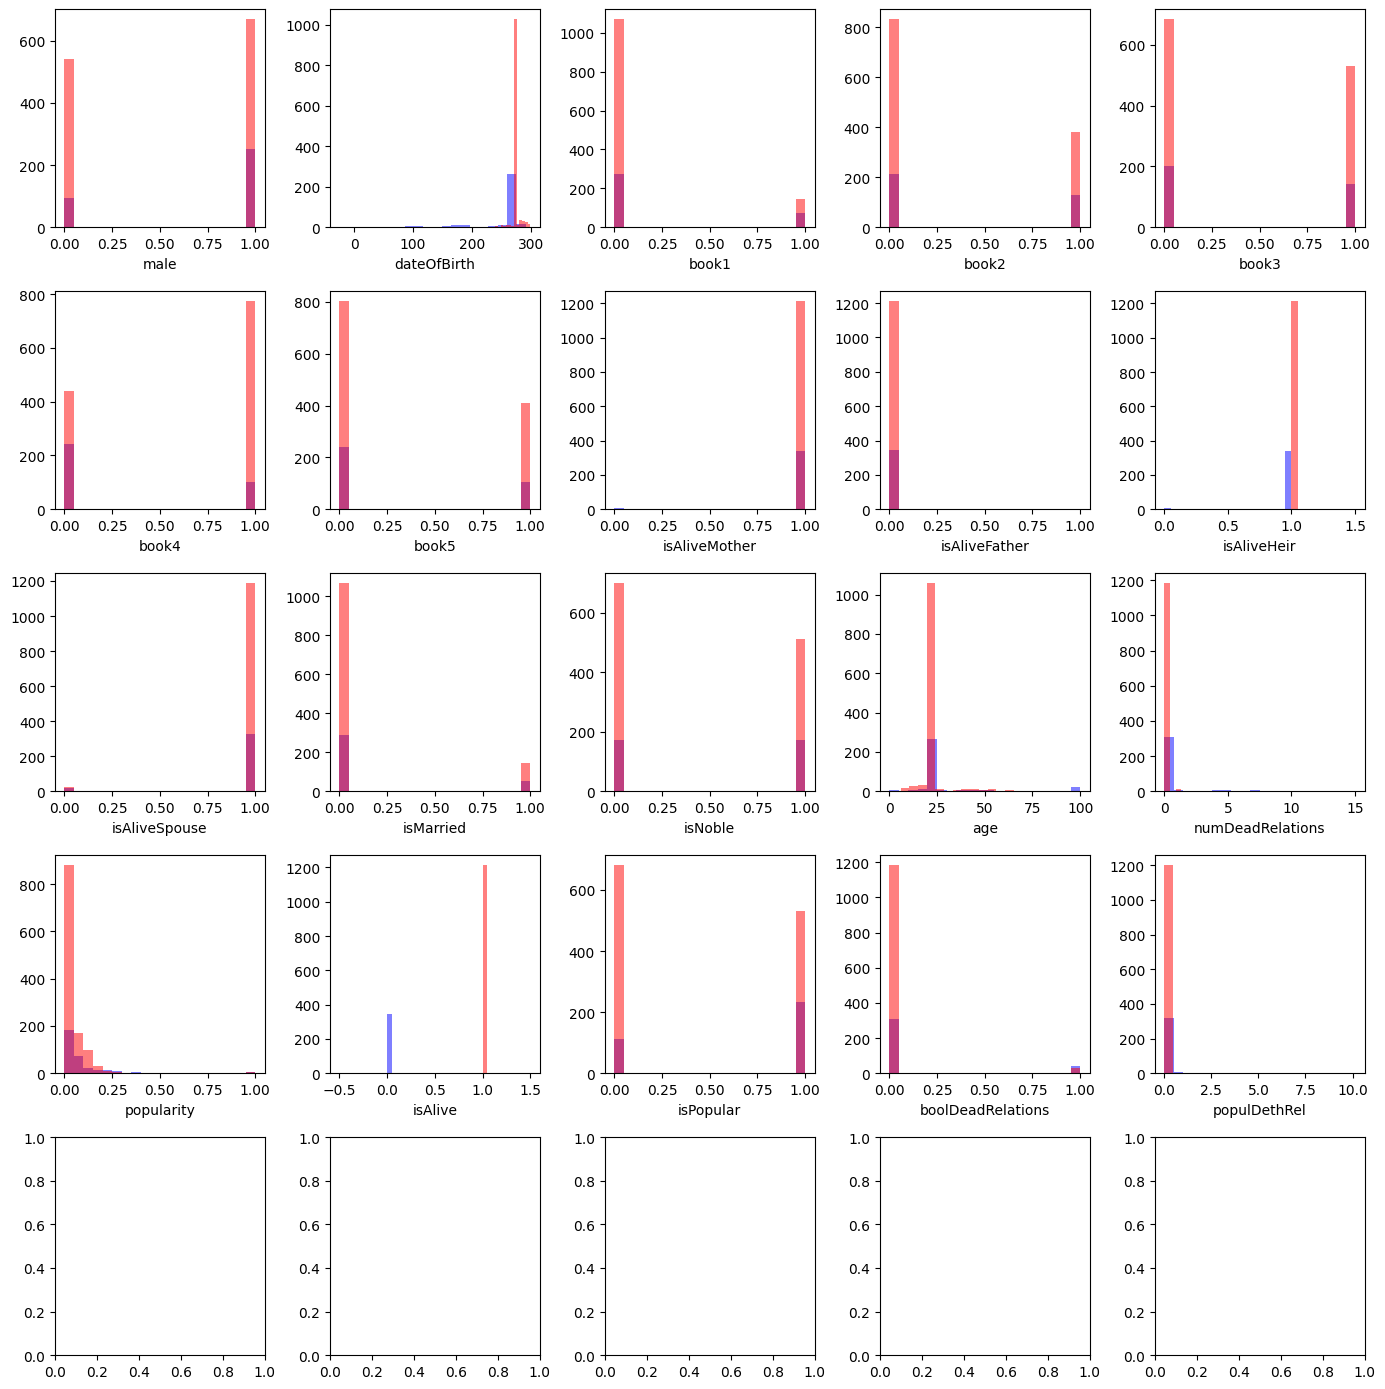

In [ ]:
numCols = [col for col in data.columns if data[col].dtype != 'object']
ncols = 5
nrows = len(numCols) // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize = (14, 14))
axs = axs.flatten()
for i, col in enumerate(numCols):
    axs[i].hist(data.loc[data.isAlive==0, col].astype('float32'), bins = 20, color='blue', alpha=0.5)
    axs[i].hist(data.loc[data.isAlive==1, col].astype('float32'), bins = 20, color='red', alpha=0.5)
    axs[i].set_xlabel(col)
fig.tight_layout()

Теперь посмотрим на графики рассеяния в связи с целевой переменной

In [ ]:
popularityPrcntAlive = np.percentile(data.loc[data.isAlive == 1, 'popularity'], range(101))
popularityPrcntNonAlive = np.percentile(data.loc[data.isAlive == 0, 'popularity'], range(101))
agePrcntAlive = np.percentile(data.loc[data.isAlive == 1, 'age'], range(101))
agePrcntNonAlive = np.percentile(data.loc[data.isAlive == 0, 'age'], range(101))
dateOfBirthPrcntAlive = np.percentile(data.loc[data.isAlive == 1, 'dateOfBirth'], range(101))
dateOfBirthPrcntNonAlive = np.percentile(data.loc[data.isAlive == 0, 'dateOfBirth'], range(101))

def getPercents(name, percents, dat):
    res = []
    for i in dat[name]:
        # print(i)
        a = percents - i
        b = np.argmin(abs(a))
        c = 100 - abs(50-b)*2
        res.append(c)

    return res

#
# getPercents('popularity', popularityPrcntAlive)
# data['popularityAlive'] = getPercents('popularity', popularityPrcntAlive, data)
# data['popularityNonAlive'] = getPercents('popularity', popularityPrcntNonAlive, data)
# data['ageAlive'] = getPercents('age', agePrcntAlive, data)
# data['ageNonAlive'] = getPercents('age', agePrcntNonAlive, data)
# data['popularityDif'] = data['popularityAlive'] > data['popularityNonAlive']
# data['ageDif'] = data['ageAlive'] > data['ageNonAlive']
# data['dateOfBirthAlive'] = getPercents('dateOfBirth', dateOfBirthPrcntAlive, data)
# data['dateOfBirthNonAlive'] = getPercents('dateOfBirth', dateOfBirthPrcntNonAlive, data)
# data['dateOfBirthDif'] = data['dateOfBirthAlive'] > data['dateOfBirthNonAlive']

data['randomVar'] = data['dateOfBirth'] + data['book4'] - data['age'] - data['popularity'] - data['book1'] - data['male'] - data['isPopular'] + data['isAliveHeir']

**Посмотрим на качественные признаки.**

Построим столбчатые диаграммы по каждому признаку отдельно для выживших и невыживших героев. Если диаграммы будут сильно перекрываться - признак не особо различается для разных категорий геров. Наиболее важными для нас будут те признаки, диаграммы по которым для категорий целевой переменной перекрываться будут не сильно.

<font color='red'>Красным</font> - выжившие, <font color='blue'>синим</font> - не выжившие.


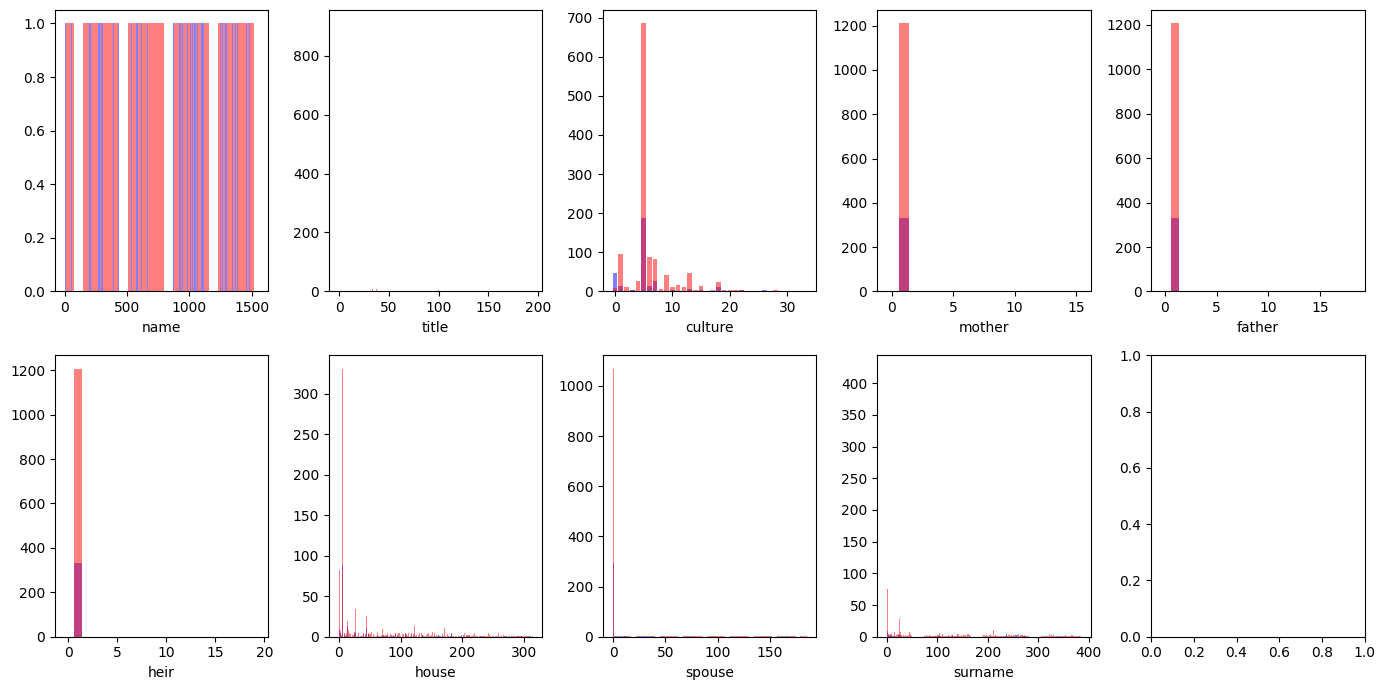

In [ ]:
catCols = [col for col in data.columns if data[col].dtype == 'object']
ncols = 5
nrows = len(catCols) // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize = (14, 7))
axs = axs.flatten()
for i, col in enumerate(catCols):
    #чтоб столбцы шли в одном и том же порядке делаем общую последовательность столбцов из всех уникальных значений категориального признака
    x = range(data[col].unique().shape[0])
    yValsAlive = data.loc[data.isAlive==1, col].value_counts()
    yValsnonAlive = data.loc[data.isAlive==0, col].value_counts()
    yAlive = [yValsAlive[i] if i in yValsAlive.index else 0 for i in data[col].unique() ]
    ynonAlive = [yValsnonAlive[i] if i in yValsnonAlive.index else 0 for i in data[col].unique() ]
    axs[i].bar(x, ynonAlive, color='blue', alpha=0.5)
    axs[i].bar(x, yAlive, color='red', alpha=0.5)
    axs[i].set_xlabel(col)
fig.tight_layout()

**Вывод по переменным**

С учётом исходного количества отсутствующих/пропущенных значений и степени расхождение гистограмм и барплотов следует избавиться от: 'mother', 'father', 'heir', 'name', 'spouse', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse'

In [ ]:
col2drop = ['mother', 'father', 'heir', 'name', 'spouse', 'surname', 'isAliveMother', 'isAliveFather',
            'isAliveHeir', 'isAliveSpouse']
data.drop(columns=col2drop, inplace = True)

**Задание 1.6.** Проанализируйте целевую переменную. Посмотрите, является ли она категориальной или количественной. Так как мы говорим о задаче классификации, проанализируйте является ли датасет сбалансированным по классам или нет.

<BarContainer object of 2 artists>

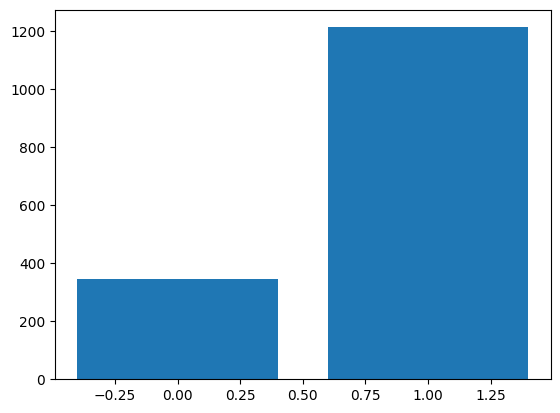

In [ ]:
y = data.isAlive.value_counts()
x = y.index
plt.bar(x, y)

Целевая переменная не сбалансирована. Соотношение количества элементов разного класса примерно 1 к 3.

Надо будет учесть при разбиении выборки на тренировочную и тестовую.

**Задание 1.7.** Проанализируйте признаки.
  * Обработайте категориальные признаки и переведите их в числа. Можете выбрать любой кодировщик.
  * Проанализируйте количественные признаки. Есть ли корреляция между признаками?

Поработаем с признаком **title**. Судя по графикам выше в нём длинный хвост малочастотных значений. Это не информативно и ни для чего не поможет.

(0.0, 10.0)

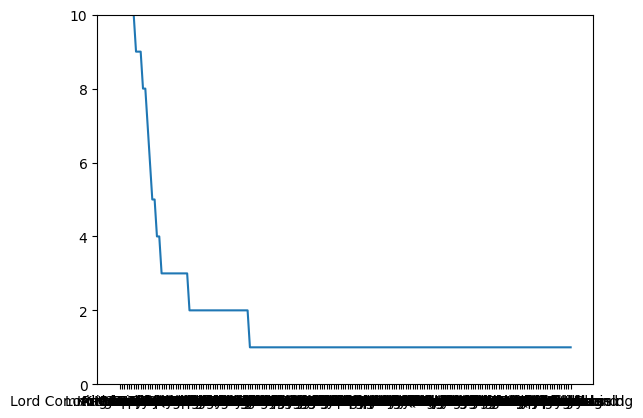

In [ ]:
plt.plot(data.title.value_counts())
plt.ylim(0, 10)

Сделаем отсечку на пороге 3: всех, кто встречается в выборке 3 раза и меньше, отнесём к "нехарактерным":

In [ ]:
titleTresh = 4
tFreqs = data.title.value_counts()
for t in data.title.unique():
    if tFreqs[t] < titleTresh:
        data.title.replace({t:'uncommon_title'}, inplace=True)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_15904\1695186020.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.title.replace({t:'uncommon_title'}, inplace=True)


Аналогичным образом поступим и с домами:

(0.0, 10.0)

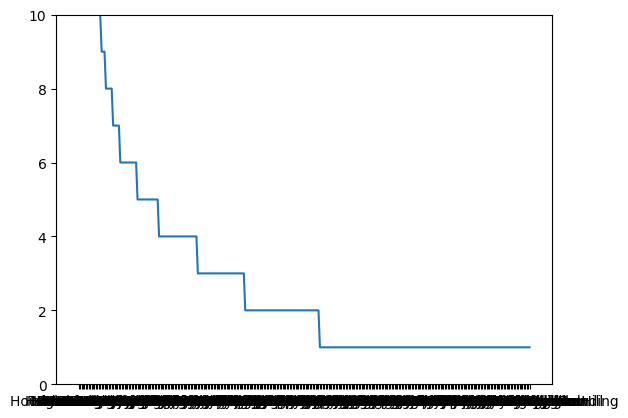

In [ ]:
plt.plot(data.house.value_counts())
plt.ylim(0, 10)

In [ ]:
houseTresh = 4
tFreqs = data.house.value_counts()
for t in data.house.unique():
    if tFreqs[t] < houseTresh:
        data.house.replace({t:'uncommon_house'}, inplace=True)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_15904\4058635155.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.house.replace({t:'uncommon_house'}, inplace=True)


Теперь преобразуем категориальные переменные в числовые:

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        data = pd.concat([data, pd.get_dummies(data[col])], axis=1)
        # print(pd.get_dummies(data[col]).columns)
        data.drop(columns=col, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1557 entries, 1 to 1557
Columns: 154 entries, male to uncommon_house
dtypes: bool(139), float64(5), int64(10)
memory usage: 406.0 KB


Как видим, все переменные преобразованы к числовым. В составе датафрейма только числовые и логические переменны.

**Задание 1.8.** Проанализируйте влияние признаков на целевую переменную.

В существенной степень влияние признаков на целевую переменную мы посмотрели в пункте 1.5, где строили гистограммы и диаграммы отдельно для разных уровней целевой переменной.

Посмотрим дополнительно на корреляции.

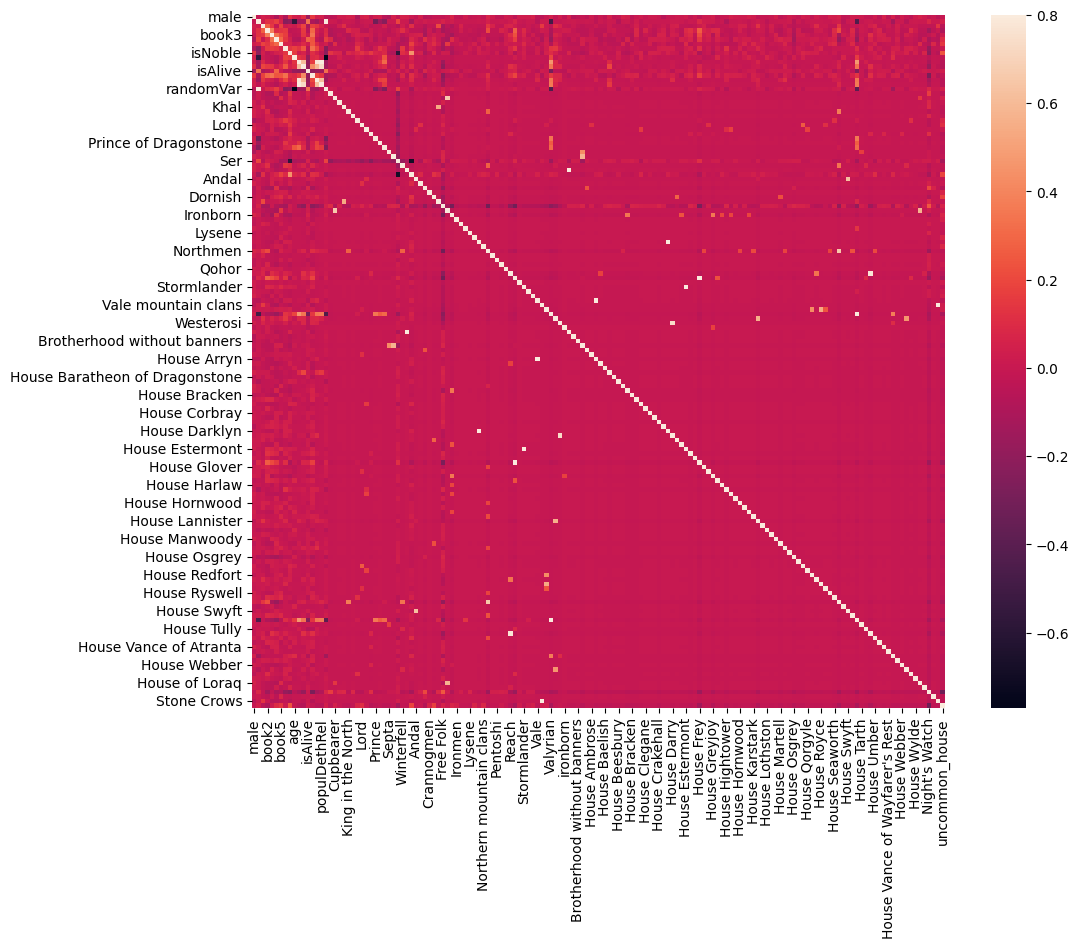

In [ ]:
import seaborn as sns
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Видим, что в четвёртой сверху строке есть несколько точек, заметно отличающихся от других по цвету - чаще в тёмную сторону. Это хорошо, эти переменные будут нам хорошо помогать в решении задачи.

**Задание 1.9.** Создайте переменные `X`, которая будет хранить только значения признаков, и `y`, которая будет хранить только значения целевой переменной.

In [ ]:
X = data.loc[:, data.columns != 'isAlive']
y = data.loc[:, 'isAlive']

**Задание 1.10.** Разделите датасет на train и test часть при помощи функции `train_test_split`

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# сразу отнормируем данные
Xm = X.mean()
Xstd = X.std()

X -= Xm
X /= Xstd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Часть 2. Обучение моделей

В данной части домашнего задания, мы хотим научиться обучать модели для задачи классификации на наших данных.

**Задание 2.1.** Импортируйте следующие модели из библиотеки `sklearn`
* LogisticRegression
* RandomForestClassifier
* AdaBoostClassifier
* GaussianProcessClassifier
* GaussianNB
* KNeighborsClassifier
* SVC
* DecisionTreeClassifier


В качестве примера, импортируем модель `LogisticRegression`

In [ ]:
from sklearn.linear_model import LogisticRegression

Импортируйте остальные модели из библиотеки `sklearn`. Чтобы понять как это сделать, воспользуйтесь официальный документацией `sklearn` $→$ [тык](https://scikit-learn.org/dev/user_guide.html). По ключевому названию модели, вы сможете найти необходимую информацию о том, как можно импортировать модель из библиотеки.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**Задание 2.2.** Обучите модель и сделайте предсказание на тестовой выборке

В качестве примера, обучим модель `LogisticRegression` и сделаем на ней предсказания на тестовой выборке.

In [ ]:
# Шаг 1. создание модели
logistic_regression = LogisticRegression(C=1, max_iter=2000)

# Шаг 2. обучение модели
logistic_regression.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_LR = logistic_regression.predict(X_test)

Аналогичным образом обучите остальные модели и сделайте предсказания на тестовой выборке.

In [ ]:
# Шаг 1. создание модели
ada_boost = AdaBoostClassifier()

# Шаг 2. обучение модели
ada_boost.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_ada = ada_boost.predict(X_test)

C:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# Шаг 1. создание модели
random_forest = RandomForestClassifier(n_estimators=500)

# Шаг 2. обучение модели
random_forest.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_RF = random_forest.predict(X_test)

In [ ]:
# Шаг 1. создание модели
gaus_pr = GaussianProcessClassifier()

# Шаг 2. обучение модели
gaus_pr.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_GR = gaus_pr.predict(X_test)

In [ ]:
# Шаг 1. создание модели
gaus_nb = GaussianNB()

# Шаг 2. обучение модели
gaus_nb.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_GNB = gaus_nb.predict(X_test)

In [ ]:
# Шаг 1. создание модели
KN = KNeighborsClassifier()

# Шаг 2. обучение модели
KN.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_KN = KN.predict(X_test)

In [ ]:
# Шаг 1. создание модели
svc = SVC()

# Шаг 2. обучение модели
svc.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_svc = svc.predict(X_test)

In [ ]:
# Шаг 1. создание модели
dtc = DecisionTreeClassifier()

# Шаг 2. обучение модели
dtc.fit(X_train, y_train)

# Шаг 3. Предсказание на тестовых данных
y_pred_dtc = dtc.predict(X_test)

## Часть 3. Оцените качество моделей

Вам необходимо познакомиться с метриками задачи классификации из sklearn. Оцените все модели и выберите лучшую по метрике качества Accuracy.

С метриками классификации вы можете ознакомиться в [Yandex ML Book](https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii).

Для простоты в данном домашнем задании мы будем работать с самой базовой метрикой для задачи классификации - accuracy.


**Задание 3.1.** Вам необходимо посчитать метрику для всех моделей и выбрать лучшую модель.

Сначала импортируем необходимую функцию из библиотеки sklearn для подсчета accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

В качестве примера, посчитаем метрику accuracy для модели `LogisticRegression`

In [ ]:
# Шаг 3. Предсказание на тестовых данных
y_pred = logistic_regression.predict(X_test)

# Шаг 4. Оценка предсказания по метрике accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : %.4f" % accuracy)

Accuracy : 0.8494


Аналогичным образом посчитайте метрику accuracy для остальных моделей

In [ ]:
for clf in (ada_boost, random_forest, gaus_pr, KN, svc, dtc):

    # Шаг 3. Предсказание на тестовых данных
    y_pred = clf.predict(X_test)

    # Шаг 4. Оценка предсказания по метрике accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(clf)
    print("Accuracy : %.4f" % accuracy)

AdaBoostClassifier()
Accuracy : 0.8397
RandomForestClassifier(n_estimators=500)
Accuracy : 0.8814
GaussianProcessClassifier()
Accuracy : 0.7917
KNeighborsClassifier()
Accuracy : 0.8109
SVC()
Accuracy : 0.8205
DecisionTreeClassifier()
Accuracy : 0.8333


Выберите лучшую модель.

Лучший результат показал **RandomForestClassifier**.

### Файл `submission.csv`

Вам нужно вместо значений в `submission.csv` файле в колонке `isAlive`, подставить свои предсказания и сохранить измененный файл.

In [ ]:
# !gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

In [ ]:
submission = pd.read_csv("submission.csv", index_col='S.No')

In [ ]:
submission

,isAlive
S.No,
1558,0
1559,0
1560,0
1561,0
1562,0
...,...
1942,0
1943,0
1944,0


Приведём данные из файла `test.csv` к виду, в котором они подавались на вход для обучения моделей.

In [ ]:
dataTest = pd.read_csv('game_of_thrones_test.csv', index_col='S.No')

In [ ]:
#восстановим культуру по фамилии
dataTest['surname'] = [nameProc(i) for i in dataTest.name]

# cultONsur = {}
# cultnans = dataTest.culture.isna() == False
cultnansT = dataTest.culture.isna()
for s in dataTest.surname.unique():
    if s in cultONsur.keys():
        family = dataTest.surname == s
        # s_cult = dataTest.loc[family, 'culture'].mode()
        # if s_cult.shape[0] > 0:
        dataTest.loc[family&cultnansT, 'culture'] = cultONsur[s]
            # cultONsur.update({s:s_cult[0]})

#восстановим дом по фамилии
# housONsur = {}
housenans = dataTest.house.isna() == False
housenansT = dataTest.house.isna()
for s in dataTest.surname.unique():
    if s in housONsur.keys():
        family = dataTest.surname == s
        # s_house = dataTest.loc[family, 'house'].mode()
        # if s_cult.shape[0] > 0:
        dataTest.loc[family&housenansT, 'house'] = housONsur[s]
            # housONsur.update({s:s_cult[0]})

In [ ]:
#поработаем с культурами и домами
cultnans = dataTest.culture.isna() == False
cultnansT = dataTest.culture.isna()
for i in dataTest.house.unique():
    if not pd.isna(i) and (i in cultONhouse.keys()):
        cond = dataTest.house == i
        if sum(cond & cultnans) > 0:
            # houseCult = dataTest.loc[cond, 'culture'].mode()[0]
            dataTest.loc[cond & cultnansT, 'culture'] = cultONhouse[i]

# nareplaceVals = {}
# for col in dataTest.columns:
#     if dataTest[col].dtype == 'object':
#         nareplaceVals.update({col : dataTest[col].mode()[0]})
#     else:
#         nareplaceVals.update({col : dataTest[col].median()})

#и заполним пропущенные значения
dataTest.fillna(value=nareplaceVals, inplace=True)

In [ ]:
dataTest['isPopular'] = dataTest['popularity'] >= populTresh
dataTest['boolDeadRelations'] = dataTest['numDeadRelations'] > 0
dataTest['populDethRel'] = dataTest['numDeadRelations'] * dataTest['popularity']

# dataTest['popularityAlive'] = getPercents('popularity', popularityPrcntAlive, dataTest)
# dataTest['popularityNonAlive'] = getPercents('popularity', popularityPrcntNonAlive, dataTest)
# dataTest['popularityDif'] = dataTest['popularityAlive'] > dataTest['popularityNonAlive']
# dataTest['ageAlive'] = getPercents('age', agePrcntAlive, dataTest)
# dataTest['ageNonAlive'] = getPercents('age', agePrcntNonAlive, dataTest)
# dataTest['ageDif'] = dataTest['ageAlive'] > dataTest['ageNonAlive']
dataTest['randomVar'] = dataTest['dateOfBirth'] + dataTest['book4'] - dataTest['age'] - dataTest['popularity'] - dataTest['book1'] - dataTest['male'] - dataTest['isPopular'] + dataTest['isAliveHeir']

In [ ]:
dataTest.drop(columns=col2drop, inplace = True)

In [ ]:
#укрупняем категории культуры
for val in dataTest['culture'].unique():
    if val.lower() in cult4replacing.keys():
        dataTest.replace(val, cult4replacing[val.lower()], inplace=True)

In [ ]:
tFreqs = dataTest.house.value_counts()
for t in dataTest.house.unique():
    if tFreqs[t] < houseTresh:
        dataTest.house.replace({t:'uncommon_house'}, inplace=True)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_15904\687299529.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTest.house.replace({t:'uncommon_house'}, inplace=True)


In [ ]:
tFreqs = dataTest.title.value_counts()
for t in dataTest.title.unique():
    if tFreqs[t] < titleTresh:
        dataTest.title.replace({t:'uncommon_title'}, inplace=True)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_15904\1131188453.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataTest.title.replace({t:'uncommon_title'}, inplace=True)


In [ ]:
for col in dataTest.columns:
    if dataTest[col].dtype == 'object':
        dataTest = pd.concat([dataTest, pd.get_dummies(dataTest[col])], axis=1)
        dataTest.drop(columns=[col], inplace = True)

In [ ]:
#добавляем недостающие колонки в Тест
for col in X.columns:
    if col not in dataTest.columns:
        dataTest[col] = False

#и убираем лишние из Теста
for col in dataTest.columns:
    if col not in X.columns:
        dataTest.drop(columns=[col], inplace=True)

In [ ]:
# for col in X.columns:
#     if col not in dataTest.columns:
#         print(col)

In [ ]:
X.shape

(1557, 153)

In [ ]:
dataTest.shape

(389, 153)

In [ ]:
#приведем порядок колонок в тесте к нужному (как в Х)
dataTest = dataTest[list(X.columns)]

In [ ]:
for i, j in zip(dataTest.columns, X.columns):
    print(i, j)

male male
dateOfBirth dateOfBirth
book1 book1
book2 book2
book3 book3
book4 book4
book5 book5
isMarried isMarried
isNoble isNoble
age age
numDeadRelations numDeadRelations
popularity popularity
isPopular isPopular
boolDeadRelations boolDeadRelations
populDethRel populDethRel
randomVar randomVar
Archmaester Archmaester
Cupbearer Cupbearer
Grand Maester Grand Maester
Khal Khal
King in the North King in the North
King-Beyond-the-Wall King-Beyond-the-Wall
Lady Lady
Lord Lord
Lord Commander of the Night's Watch Lord Commander of the Night's Watch
Maester Maester
Prince Prince
Prince of Dragonstone Prince of Dragonstone
Princess Princess
Septa Septa
Septon Septon
Ser Ser
Winterfell Winterfell
Wisdom Wisdom
uncommon_title uncommon_title
Andal Andal
Astapori Astapori
Braavosi Braavosi
Crannogmen Crannogmen
Dornish Dornish
Dothraki Dothraki
Free Folk Free Folk
Ghiscari Ghiscari
Ironborn Ironborn
Ironmen Ironmen
Lhazareen Lhazareen
Lhazarene Lhazarene
Lysene Lysene
Meereenese Meereenese
Myrish M

первая попытка - на троечку

попробуем нормализовать данные и обучиться на всей выборке

In [ ]:
# Xm = X.mean()
# Xstd = X.std()

# X -= Xm
# X /= Xstd
# for col in X.columns:
#     X[col] = X.male

dataTest -= Xm
dataTest /= Xstd

In [ ]:
ada_boost.fit(X, y)

pred = ada_boost.predict(dataTest)

C:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Как сохранить измененный Pandas DataFrame в csv файл:

In [ ]:
submission.isAlive = pred
submission.to_csv("new_submission8.csv", index=False)